In [14]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd
import networkx as nx

# from numba import njit
from numpy.lib.stride_tricks import sliding_window_view

#import pyproj
#pyproj.datadir.set_data_dir('/opt/anaconda3/envs/maps/share/proj')
#pyproj.datadir.get_data_dir()
#pyproj.show_versions()

In [15]:
print(np.__version__)
print(matplotlib.__version__)

1.26.4
3.8.4


In [16]:
import sys
print(sys.executable)

/Users/ismailsaadi/anaconda3/envs/jibe/bin/python


In [17]:
# datasets
trips=pd.read_csv('Data/Adults/Trips.csv',sep=';')
participants=pd.read_csv('Data/Adults/Participants.csv',sep=';')
moves=pd.read_csv('Data/Adults/Moves.csv',sep=';')
intake=pd.read_csv('Data/Adults/Intake.csv',sep=';',low_memory=False)
carsinfo=pd.read_csv('Data/Adults/CarsInfo.csv',sep=';')

# kids
participants_k=pd.read_csv('Data/Kids/Participants_K.csv',sep=';')
intake_k=pd.read_csv('Data/Kids/Intake_K.csv',sep=';',low_memory=False)
trips_k=pd.read_csv('Data/Kids/Trips_K.csv',sep=';')
moves_k=pd.read_csv('Data/Kids/Moves_K.csv',sep=';')

trips_all = pd.concat([trips, trips_k])
participants_all = pd.concat([participants, participants_k])

# Upload map at commune level
mp=gpd.read_file('bmap_commune.geojson') # 'bmap/BELGIUM_-_Municipalities.shp'
mp['CODE_INS']=mp.CODE_INS.astype(int)
mp['arrond']=mp.arrond.astype(int)

# to convert from ins to postalcode 2014 V
eq=pd.read_csv('equi.csv',sep=';')
table_postCode_ins=eq[["postalcode", "refins"]]

# weights
w=pd.read_csv('Data/Weights_28JUN2018.csv',sep=';')
w['weights_pop']=pd.to_numeric([k.replace(',','.') for k in w.WeightPOP])
w['weights_smp']=pd.to_numeric([k.replace(',','.') for k in w.WeightSMP])


# IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer
#trip["t_source_PostCode"]=trips.t_source_PostCode.astype(int)
#trip["t_destination_PostCode"]=trips.t_destination_PostCode.astype(int)

trips=pd.merge(trips, w[["p_id","weights_pop"]], left_on="t_participant_id", right_on="p_id")
#trips=pd.merge(trips, table_postCode_ins, left_on="t_source_PostCode", right_on="refins")
trips.head()

# filter Liège
# Liège - 62
# Verviers - 63
# Huy - 61
# Waremme - 64

prov_liege=mp[(mp.arrond==61) | (mp.arrond==62) | (mp.arrond==63) | (mp.arrond==64)]

In [18]:
trips_all.head()

,t_id,t_participant_id,t_source_hour,t_source_minute,t_source,t_source_foreign,t_source_id,t_destination_hour,t_destination_minute,t_destination,...,t_reason_other,t_created,t_updated,duration,t_reason7,t_reason14,t_source_PostCode,t_destination_PostCode,reason_OVG,reason_NEW
0,1349,1167,14,45,9200 - DENDERMONDE,0.0,1348.0,15,5,1785 - MERCHTEM,...,NaN,"42534,87609","42534,87609",20,7,7,9200.0,1785.0,1.0,1.0
1,1350,1167,15,40,1785 - MERCHTEM,0.0,1349.0,15,45,1785 - MERCHTEM,...,NaN,"42534,87646","42534,87646",5,4,4,1785.0,1785.0,4.0,4.0
2,1353,1167,20,20,1785 - MERCHTEM,0.0,1352.0,20,30,1785 - MERCHTEM,...,NaN,"42534,87788","42534,87788",10,6,6,1785.0,1785.0,6.0,6.0
3,1348,1167,6,30,1785 - MERCHTEM,0.0,NaN,6,50,9200 - DENDERMONDE,...,NaN,"42534,8756","42534,8756",20,1,1,1785.0,9200.0,1.0,1.0
4,1413,1243,17,2,9000 - GENT,0.0,1412.0,17,25,9080 - LOCHRISTI,...,NaN,"42535,41767","42535,41767",23,5,back 5,9000.0,9080.0,1.0,1.0


In [212]:
#

od_mpd = pd.read_csv("transportation-paper/od_matrix_absolute_trip_flow_MPD.csv", sep=",")
od_mpd.set_index('Unnamed: 0', inplace=True)
od_monitor = pd.read_csv("transportation-paper/od_matrix_absolute_trip_flow_MONITOR.csv", sep=",")
od_monitor.set_index('Unnamed: 0', inplace=True)

od_monitor = od_monitor.reindex(index=od_mpd.index)
od_monitor= od_monitor[od_mpd.columns]

od_other = pd.read_csv("transportation-paper/od_pairs_mobile_monitor_kdtree_weights.csv", sep=",")

In [115]:
od_other.head()

,origin,destination,tijMon,tijMP,dMon,dMP,shortest_path_len,shortest_path_time
0,61003,61003,4965.0,2527.0,0.001,0.001,0.000,0.0
1,61003,61010,0.0,0.0,15.381,15.079,20434.400,50.0
2,61003,61012,0.0,0.0,15.664,16.015,20571.019,60.0
3,61003,61019,0.0,0.0,27.288,27.974,36523.100,86.0
4,61003,61024,0.0,0.0,21.538,21.662,29918.508,84.0


In [213]:
##
od_dist= pd.pivot_table(od_other, values= "dMon", index= "origin", columns= "destination", fill_value=0)
od_dist = od_dist.reindex(index=od_mpd.index)
od_dist= od_dist[od_mpd.columns.astype(int)]
od_dist.head()


##
od_dist_mpd= pd.pivot_table(od_other, values= "dMP", index= "origin", columns= "destination", fill_value=0)
od_dist_mpd = od_dist_mpd.reindex(index=od_mpd.index)
od_dist_mpd= od_dist_mpd[od_mpd.columns.astype(int)]
od_dist_mpd.head()

destination,61041,61003,61010,61012,61019,61024,61028,61031,61039,61043,...,64034,64047,64056,64063,64065,64074,64075,64076,62051,62118
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
61041,0.001,8.782,18.157,7.462,24.427,18.168,16.214,7.592,4.489,8.380,...,26.796,33.539,27.472,23.679,13.517,24.444,24.938,19.605,31.422,20.651
61003,8.782,0.001,15.079,16.015,27.974,21.662,14.980,8.416,10.294,7.703,...,21.103,27.193,18.699,14.909,5.482,15.835,21.601,11.463,25.279,13.257
61010,18.157,15.079,0.001,24.565,41.979,35.594,3.637,10.627,15.032,22.342,...,10.130,17.117,23.582,20.907,18.633,17.816,6.830,12.747,37.724,25.298
61012,7.462,16.015,24.565,0.001,21.173,15.745,22.013,14.054,9.536,12.777,...,33.805,40.671,34.519,30.734,20.144,31.816,31.120,27.061,35.848,26.482
61019,24.427,27.974,41.979,21.173,0.001,6.387,40.514,31.847,28.663,20.286,...,49.076,55.038,40.497,37.457,27.941,40.948,48.799,38.439,30.626,28.927


In [136]:
od_mpd.head(10)

,61041,61003,61010,61012,61019,61024,61028,61031,61039,61043,...,64034,64047,64056,64063,64065,64074,64075,64076,62051,62118
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
61041,4101,1,0,1279,0,0,0,1155,803,299,...,0,0,0,0,1,2,0,0,0,0
61003,1,5301,0,0,0,0,0,2388,9,38,...,0,0,0,0,769,13,0,0,2,0
61010,0,0,3927,0,0,0,273,195,0,0,...,284,0,0,0,0,22,173,0,0,0
61012,1263,0,0,2872,9,1,0,278,244,7,...,0,0,0,0,0,0,0,0,0,0
61019,0,0,0,5,2189,1003,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
61024,0,0,0,0,995,1863,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61028,0,0,261,0,0,0,3463,554,1,0,...,110,0,0,0,0,0,40,0,0,0
61031,1189,2421,190,287,0,1,548,18752,1903,388,...,158,1,0,1,423,242,1,91,14,24
61039,807,7,0,245,0,0,3,1884,862,2,...,1,0,0,0,2,3,0,0,0,0


In [254]:
od_dist.head()

destination,61041,61003,61010,61012,61019,61024,61028,61031,61039,61043,...,64034,64047,64056,64063,64065,64074,64075,64076,62051,62118
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
61041,0.001,8.868,18.797,7.149,23.827,18.432,15.810,6.867,4.473,8.537,...,26.853,33.731,27.948,23.753,14.317,24.638,25.389,19.521,31.638,20.704
61003,8.868,0.001,15.381,15.664,27.288,21.538,14.682,7.997,10.797,7.474,...,21.044,27.473,19.089,14.896,5.970,15.988,21.578,11.327,25.302,13.064
61010,18.797,15.381,0.001,25.247,41.821,36.133,4.705,11.977,16.214,22.560,...,9.456,16.253,23.468,20.564,18.549,17.119,6.602,12.275,37.520,24.815
61012,7.149,15.664,25.247,0.001,20.265,15.821,21.657,13.358,9.137,12.470,...,33.747,40.672,34.501,30.321,20.501,31.621,31.737,26.626,35.493,26.052
61019,23.827,27.288,41.821,20.265,0.001,5.750,39.483,30.458,27.901,19.841,...,48.332,54.665,40.127,36.768,28.015,40.569,48.357,37.651,30.518,28.693


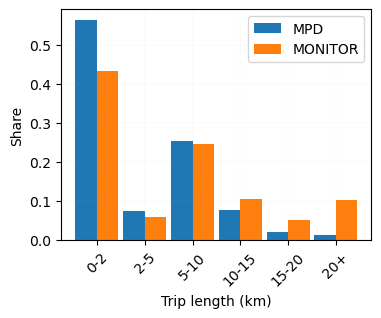

In [273]:
## mask

mask3=np.ones((od_mpd.shape[0], od_mpd.shape[1]), dtype=bool)
np.fill_diagonal(matrix, False)

mask1= od_mpd>0
mask2= od_monitor>0
mask_combined = (mask1 | mask2) # & mask3 


##
bins = [0, 2, 5, 10, 15, 20, float('inf')]
# bins=2**5
density=False


fig, ax=plt.subplots(figsize=(4,3))

h1=np.histogram(od_dist_mpd.values[mask_combined.values].reshape(-1), 
         bins=bins, 
         weights= od_mpd.values[mask_combined.values].reshape(-1), 
         density=density)

h2=np.histogram(od_dist.values[mask_combined.values].reshape(-1), 
         bins=bins, 
         weights=od_monitor.values[mask_combined.values].reshape(-1),
         density=density)


#ax.plot((h1[1][1:]+h1[1][:-1])/2, h1[0]/h1[0].sum(), "-s", lw=0.1, label="MPD")
#ax.plot((h2[1][1:]+h2[1][:-1])/2, h2[0]/h2[0].sum(), "-s", lw=0.1, label="MONITOR")

width=.45
ax.bar(np.arange(6)-width/2, h1[0]/h1[0].sum(), width=width, label="MPD")
ax.bar(np.arange(6)+width/2, h2[0]/h2[0].sum(), width=width, label="MONITOR")
ax.set_xticks(np.arange(6), ['0-2', '2-5', '5-10', '10-15', '15-20', '20+'], rotation=45)
#ax.set_xticklabels()

#ax.set_xticks()

#plt.xlim(-5, 50)
ax.grid(True, lw=0.05)

#plt.xscale('log')  # Set x-axis to logarithmic scale
#plt.yscale('log')  # Set y-axis to logarithmic scale

#ax.set_xlim([-5, 40])
ax.legend()
ax.set_xlabel("Trip length (km)")
ax.set_ylabel("Share")

plt.show()

fig.savefig('transportation-paper/fig-distances-distributions.pdf', bbox_inches='tight', dpi=400)

In [20]:
# municipality_wallonia = pd.read_csv("transportation-paper/munity_wallonia_geometry.csv", sep=",")
# municipality_wallonia

In [21]:
# 31370
# municipality_wallonia.head()

from shapely.geometry import Point

municipality_wallonia = pd.read_csv("transportation-paper/munity_wallonia_geometry.csv", sep=",")
municipality_wallonia=municipality_wallonia[municipality_wallonia.CNIS5_2022.isin(od_mpd.index)].set_index("CNIS5_2022").reindex(index=od_mpd.index)

gdf = gpd.GeoDataFrame(municipality_wallonia["T_MUN_FR"], geometry=[Point(xy) for xy in zip(municipality_wallonia['INSIDE_X'], municipality_wallonia['INSIDE_Y'])])
gdf=gdf.set_crs(31370)
gdf=gdf.to_crs(3857)

np_coordinates=np.concatenate((gdf.geometry.x.values.reshape(-1,1), gdf.geometry.y.values.reshape(-1,1)), axis=1)

/var/folders/4b/fvthcgyn1ng5hl03y3brw72w0000gn/T/ipykernel_7881/3726106282.py:9: RuntimeWarning: invalid value encountered in divide
  return x/div
/var/folders/4b/fvthcgyn1ng5hl03y3brw72w0000gn/T/ipykernel_7881/3726106282.py:6: RuntimeWarning: invalid value encountered in divide
  return x/div


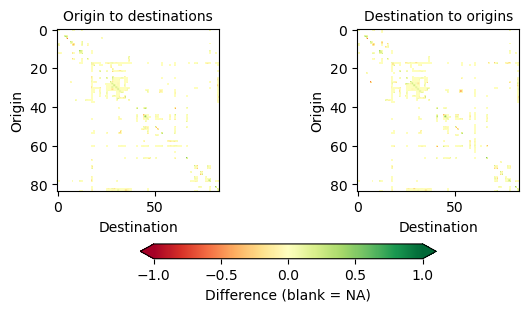

In [22]:
# cellwise difference

def normalize(x, axis=0):
    div=np.sum(x, axis=axis)
    if axis==0:
        return x/div
    else:
        div=div[:, np.newaxis]
        return x/div

def inf_to_zero(x):
    inf_mask = np.isinf(x)
    x[inf_mask] = np.nan
    return x

A=normalize(od_mpd.values, axis=1)
B=normalize(od_monitor.values, axis=1)

Ad=normalize(od_mpd.values, axis=0)
Bd=normalize(od_monitor.values, axis=0)

from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

scale_factor=1.5
fig_size = np.array([4, 2]) * scale_factor
fig, ax=plt.subplots(figsize=fig_size, ncols=2, layout= "constrained")

cmap='RdYlGn'

C=(A-B)
Cd=(Ad-Bd)

C[C == 0] = np.nan
Cd[Cd == 0] = np.nan

im= ax[0].imshow(C, cmap=cmap, vmin=-1, vmax=1) # norm=LogNorm()
im2= ax[1].imshow(Cd, cmap=cmap, vmin=-1, vmax=1) # norm=LogNorm()

#divider = make_axes_locatable(ax[1])
#cax = divider.append_axes("top", size="5%", pad=0.2)
#cbar = fig.colorbar(im2, cax=cax, label='non-zero', extend='both')
fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.05, shrink=0.5, label="Difference (blank = NA)", extend='both')

#fig.legend(legendEntries,ncol=len(["yes", "no"]),loc="upper center")

#ax[0].set_aspect('equal')
#ax[1].set_aspect('equal')

ax[0].set_title("Origin to destinations", fontsize=10)
ax[1].set_title("Destination to origins", fontsize=10)
ax[0].set_ylabel("Origin", fontsize=10)
ax[0].set_xlabel("Destination", fontsize=10)

ax[1].set_ylabel("Origin", fontsize=10)
ax[1].set_xlabel("Destination", fontsize=10)

fig.savefig('transportation-paper/diff-error.pdf', bbox_inches='tight', dpi=400)

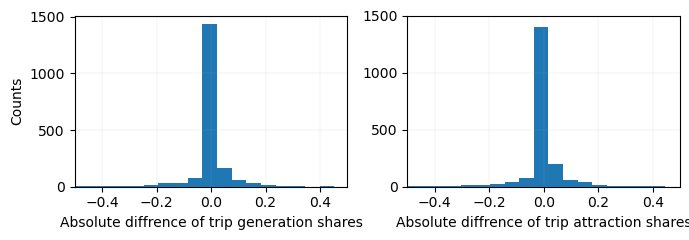

In [23]:
fig, ax= plt.subplots(ncols=2, figsize=(7, 2.5), tight_layout=True)

def mask_nan_and_zero(x):
    non_zero_mask = x!=0
    non_nan_mask = ~np.isnan(x)
    combined_mask = non_zero_mask & non_nan_mask
    non_zero_non_nan_elements = x[combined_mask]
    return non_zero_non_nan_elements

ax[0].hist(mask_nan_and_zero(C), bins=32, density=False)
ax[1].hist(mask_nan_and_zero(Cd), bins=32, density=False)

#ax[0].axvline(x=np.mean(mask_nan_and_zero(C)), color='red', linestyle='--', linewidth=2, label='Mean')
#ax[1].axvline(x=np.mean(mask_nan_and_zero(Cd)), color='red', linestyle='--', linewidth=2, label='Mean')

#mean_value= np.mean(mask_nan_and_zero(C))
#ax[0].text(mean_value, 10, f'Mean: {mean_value:.2f}', color='k', fontsize=12, ha='center')

ax[0].grid(True, lw=0.1)
ax[1].grid(True, lw=0.1)

ax[0].set_xlim([-0.5, 0.5])
ax[1].set_xlim([-0.5, 0.5])

#ax[0].set_ylim([0, 1500])
#ax[1].set_ylim([0, 1500])

ax[0].set_xlabel("Absolute diffrence of trip generation shares")
ax[1].set_xlabel("Absolute diffrence of trip attraction shares")

ax[0].set_yticks([0, 500, 1000, 1500])
ax[1].set_yticks([0, 500, 1000, 1500])

ax[0].set_ylabel("Counts")
plt.show()

fig.savefig('transportation-paper/diff-error-hist.pdf', bbox_inches='tight', dpi=400)

In [24]:
# od_other[["origin", "destination", "dMon"]]

# to make sure the order is correct
# od_dist= od_other.pivot(index='origin', columns='destination', values='dMon').fillna(0)
# od_dist.reindex(index=od_mpd.index, columns= od_mpd.columns.astype(int))
# od_dist

# random matrix to check

def generate_random_matrix(n, P):
    random_matrix = np.random.rand(n, n)
    normalized_matrix = random_matrix / np.sum(random_matrix)
    scaled_matrix = normalized_matrix * P
    return scaled_matrix

# n = 4
# P = 100
# random_matrix = np.round(generate_random_matrix(n, P),0)

In [31]:
# define the kernel and slide over the matrices

def MSSIM(A, B, distOD, kernel_shape=(3, 3), C=(1., 1.)):
    ssim=0.
    C1=C[0]
    C2=C[1]
    a=sliding_window_view(A, kernel_shape)
    b=sliding_window_view(B, kernel_shape)

    # print(a.shape)

    # slide over the matrices given the kernel
    for i in range(a.shape[0]):
        for j in range(a.shape[1]):

            dist=np.zeros(a[i,j,:,:].shape) # the distances
            weights=np.zeros(a[i,j,:,:].shape) # the weights
            
            # get central cell of the window

            # compute distances
            xkernel=a[i,j,:,:].shape[0]//2+i # originODi
            ykernel=a[i,j,:,:].shape[0]//2+j # destinationODi

            for ii in range(a[i,j,:,:].shape[0]):
                for jj in range(a[i,j,:,:].shape[1]):
                    xxkernel=i+ii # originODk
                    yykernel=j+jj # destinationODk

                    p1=(distOD[xkernel,:]- distOD[xxkernel,:])**2 # coordinates originODk
                    p2=(distOD[ykernel,:]- distOD[yykernel,:])**2 # coordinates destinationODk
                    dist[ii,jj]= np.sqrt(np.sum(p1+p2))
            
            weights=np.exp(-(dist**2)/np.var(dist))
            #weights=np.ones(weights.shape)
            #print(weights)

            # with distance effect
            mu_a= np.average(a[i,j,:,:].flatten(), weights=weights.flatten()) 
            mu_b= np.average(b[i,j,:,:].flatten(), weights=weights.flatten())
            var_a= np.average((a[i,j,:,:].flatten() - mu_a)**2, weights=weights.flatten())
            var_b= np.average((b[i,j,:,:].flatten() - mu_b)**2, weights=weights.flatten())
            cov_ab_weighted = np.average((a[i,j,:,:].flatten() - mu_a) * (b[i,j,:,:].flatten() - mu_b), weights=weights.flatten())
            ssim+=(2*mu_a*mu_b+C1)*(2*cov_ab_weighted+C2)/((mu_a**2+mu_b**2+C1)*(var_a**2+var_b**2+C2))

            # without distance effect
            #mu_a= np.mean(a[i,j,:,:]) 
            #mu_b= np.mean(b[i,j,:,:])
            #var_a= np.var(a[i,j,:,:])
            #var_b= np.var(b[i,j,:,:])
            #cov_ab= np.cov(np.stack((a[i,j,:,:].flatten(), b[i,j,:,:].flatten()), axis=1), rowvar=False)
            #ssim+=(2*mu_a*mu_b+C1)*(2*cov_ab[0,1]+C2)/((mu_a**2+mu_b**2+C1)*(var_a**2+var_b**2+C2))

    return np.round(ssim/(a.shape[0]*a.shape[1]), 2)
            


#k_list= [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]
k_list= [3, 5, 7, 9]
results= np.zeros((len(k_list), 3))

for i in range(len(k_list)):
    k=k_list[i]
    
    random_matrix = np.round(generate_random_matrix(od_mpd.shape[0], np.sum(od_mpd.values)),0)
    surv_matr=MSSIM(od_monitor.values, od_mpd.values, np_coordinates, (k, k), (4920721.7929, 92238352.6464))
    rnd_matr=MSSIM(random_matrix, od_mpd.values, np_coordinates, (k, k), (4920721.7929, 92238352.6464))

    results[i, 0]= k
    results[i, 1]= surv_matr
    results[i, 2]= rnd_matr

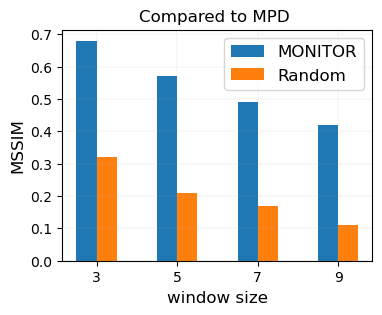

In [53]:
#np.savetxt('transportation-paper/output_mssim_survey_rnd.csv', results, delimiter=',', header='k,survey,rnd', comments='')

fig, ax=plt.subplots(figsize=(4, 3))
#ax.plot(results[:, 0], results[:, 1])
#ax.plot(results[:, 0], results[:, 2])
width=.5
ax.bar(results[:, 0]-width/2, results[:, 1], width=width, label="MONITOR")
ax.bar(results[:, 0]+width/2, results[:, 2], width=width, label="Random")

ax.grid(True, lw=0.1)
ax.set_xlabel("window size", fontsize= 12.)
ax.set_ylabel("MSSIM", fontsize= 12.)
ax.set_title("Compared to MPD ", fontsize= 12.)
ax.set_xticks(results[:, 0], results[:, 0].astype(int))
ax.legend(fontsize=12.)
fig.savefig('transportation-paper/fig-mssim.pdf', bbox_inches='tight', dpi=400)
plt.show()

In [54]:
lookup_table= pd.read_csv("belgian-cities-geocoded.csv", sep=",")
postal_codes_liege= lookup_table[lookup_table.province=="Luik"]["postal"]

In [55]:
od_travelSurvey=pd.DataFrame(0, index=lookup_table["postal"].unique(), columns=lookup_table["postal"].unique())

# update the OD matrix
for i,j in zip(trips["t_source_PostCode"], trips["t_destination_PostCode"]):
    # print(i, j)
    if not (np.isnan(i)|np.isnan(j)):
        od_travelSurvey.loc[i,j] +=1

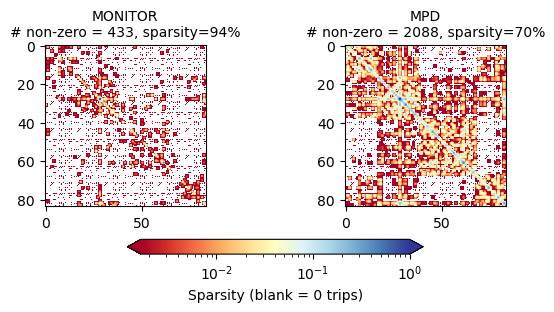

In [56]:
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

scale_factor=1.5
fig_size = np.array([4, 2]) * scale_factor
fig, ax=plt.subplots(figsize=fig_size, ncols=2, layout= "constrained")

cmap='RdYlBu'
im= ax[0].imshow(od_monitor.values/max(od_monitor.values.reshape(-1)), cmap=cmap, norm=LogNorm()) # norm=LogNorm()
im2= ax[1].imshow(od_mpd.values/max(od_mpd.values.reshape(-1)), cmap=cmap, norm=LogNorm()) # norm=LogNorm()

#divider = make_axes_locatable(ax[1])
#cax = divider.append_axes("top", size="5%", pad=0.2)
#cbar = fig.colorbar(im2, cax=cax, label='non-zero', extend='both')
fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.05, shrink=0.5, label="Sparsity (blank = 0 trips)", extend='both')

#fig.legend(legendEntries,ncol=len(["yes", "no"]),loc="upper center")

#ax[0].set_aspect('equal')
#ax[1].set_aspect('equal')

ax[0].set_title("MONITOR\n# non-zero = 433, sparsity=94%", fontsize=10)
ax[1].set_title("MPD\n# non-zero = 2088, sparsity=70%", fontsize=10)

fig.savefig('transportation-paper/sparcity.pdf', bbox_inches='tight', dpi=400)

In [57]:
def get_ongoing_trips(trips):
    # departure counts
    bins=list(range(26))
    dep= np.histogram(trips["t_source_hour"]+trips["t_source_minute"]/60, bins, weights=np.round(trips["weights_pop"], 0))
    dep = np.cumsum(dep[0])
    arr= np.histogram(trips["t_destination_hour"]+trips["t_destination_minute"]/60, bins, weights=np.round(trips["weights_pop"], 0))
    arr = np.cumsum(arr[0])
    return dep-arr

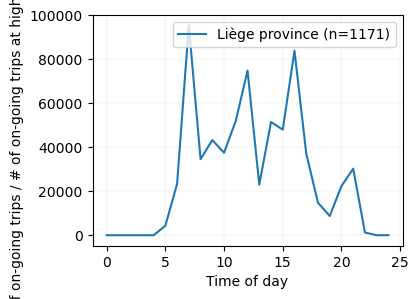

In [58]:
# filter to keep liege trips
f=  trips["t_source_PostCode"].isin(postal_codes_liege) | trips["t_destination_PostCode"].isin(postal_codes_liege)
trips_liege_province= trips[f]

fig, ax=plt.subplots(figsize=(4,3))

#liege
diff=get_ongoing_trips(trips_liege_province)
diff[diff<0]=0
ax.plot(diff)

#belgium
diff=get_ongoing_trips(trips)
diff[diff<0]=0
#ax.plot(diff/sum(diff))
ax.grid(True, lw=0.1)

ax.legend(["Liège province (n=1171)", "Belgium (n=21047)"])
ax.set_xlabel("Time of day")
ax.set_ylabel("# of on-going trips / # of on-going trips at highest peak")

fig.savefig('fig.pdf', bbox_inches='tight', dpi=400)

In [59]:
mpd_data=pd.read_csv("transportation-paper/total_trip_generation_attraction_mobile_monitor_84Zones.csv")
mpd_data.population=mpd_data.population/1000
mpd_data=mpd_data.replace(0, np.nan)
mpd_data.monitor_o=mpd_data.monitor_o/mpd_data.population
mpd_data.monitor_d=mpd_data.monitor_d/mpd_data.population

In [60]:
# all trips

p_df= pd.merge(participants_all, eq, left_on="Postcode", right_on="postalcode")
p_df = pd.merge(p_df, trips_all["t_participant_id"].value_counts().reset_index(), left_on="p_id", right_on="t_participant_id")
p_gdf=p_df[["refins", "count"]].groupby("refins").sum().reset_index()
p_gdf=pd.merge(p_gdf, mpd_data[["munity", "population"]], left_on="refins", right_on="munity")
p_gdf["density"]=p_gdf["count"]/p_gdf["population"]
#p_gdf["density"]

/var/folders/4b/fvthcgyn1ng5hl03y3brw72w0000gn/T/ipykernel_7881/1403066238.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("OrRd", num_levels)


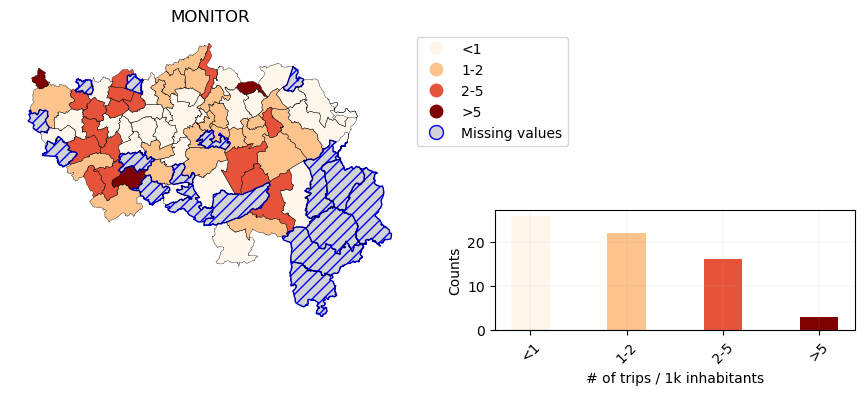

In [61]:
# Define custom bins
bins = [0, 1, 2, 5, p_gdf["density"].max()]
labels = ['<1', '1-2', '2-5','>5']
p_gdf['bins'] = pd.cut(p_gdf["density"], bins=bins, labels=labels, include_lowest=True)

# fig, ax=plt.subplots(tight_layout=True, ncols=2, nrows=1, figsize= (2*4,2.5))
# (left, bottom, width, height)
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_axes([0., 0., .75, .75]) 
ax2 = fig.add_axes([.85, 0., 0.6, 0.3])





gdf_liege= pd.merge(prov_liege, p_gdf, left_on="CODE_INS", right_on="refins", how='left')
gdf_liege.plot(column="bins", # monitor_o
               cmap= "OrRd", 
               ax=ax1,
               categorical=True,
               legend=True, 
               legend_kwds={'bbox_to_anchor': (1., 1.), 'loc': 'upper left'},
               missing_kwds={'color': 'lightgrey','edgecolor': 'blue','hatch': '///','label': 'Missing values'}
               #scheme='quantiles'
              )
gdf_liege.boundary.plot(ax=ax1, color='k', lw=.25)
ax1.set_title("MONITOR")

# plt.tight_layout()
ax1.axis('off')
#ax[1].set_aspect('auto')




# barplot
num_levels=4
cmap = plt.cm.get_cmap("OrRd", num_levels)
colors = [cmap(i) for i in np.linspace(0, 1, num_levels)]

l=gdf_liege.bins.value_counts(sort=False)
ax2.bar(l.index.astype(str), l.values, width=.4, color=colors)
ax2.grid(True, lw=0.1)
ax2.set_xticks(range(len(l.index.astype(str))))
ax2.set_xticklabels(l.index.astype(str), rotation=45)
ax2.set_ylabel("Counts")
ax2.set_xlabel("# of trips / 1k inhabitants")
plt.show()


fig.savefig('transportation-paper/fig-density-mv.pdf', bbox_inches='tight', dpi=400)

In [68]:
df_dep_arr= pd.read_csv("transportation-paper/monitor_mobile_beldam_hourly_departures_arrivals.csv")
df_dep_arr.head()

,hour,mobile_dep,mobile_arr,beldam_dep,beldam_arr,monitor_dep,monitor_arr
0,0.0,31307.0,37458.0,8660.0,9386.0,3777.0,3777.0
1,1.0,31307.0,37458.0,1209.0,2761.0,6148.0,2371.0
2,2.0,31307.0,37458.0,2979.0,2528.0,6478.0,9714.0
3,3.0,31307.0,37458.0,1522.0,1735.0,928.0,1468.0
4,4.0,31307.0,37458.0,270.0,509.0,7755.0,2629.0


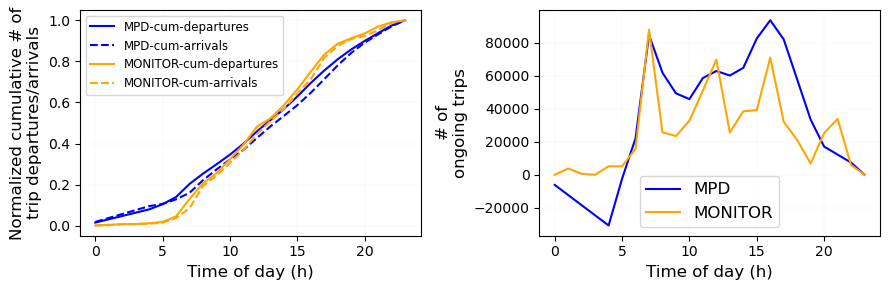

In [112]:
def cumulate(x, normalize=False):
    if normalize:
        return np.cumsum(x)/max(np.cumsum(x))
    else:
        return np.cumsum(x)

cumulate(df_dep_arr["mobile_dep"])

fontsize=12.

fig, ax=plt.subplots(ncols=2,figsize= (2.25*4, 3), tight_layout=True)

# fig1
ax[0].plot(cumulate(df_dep_arr["mobile_dep"], True), color= "blue", label="MPD-cum-departures")
ax[0].plot(cumulate(df_dep_arr["mobile_arr"], True), "--", color= "blue", label="MPD-cum-arrivals")
ax[0].plot(cumulate(df_dep_arr["monitor_dep"], True), color= "orange", label="MONITOR-cum-departures")
ax[0].plot(cumulate(df_dep_arr["monitor_arr"], True), "--", color= "orange", label="MONITOR-cum-arrivals")
ax[0].grid(True, lw=0.1/2)
ax[0].set_xlabel("Time of day (h)", fontsize=fontsize)
ax[0].set_ylabel("Normalized cumulative # of\ntrip departures/arrivals", fontsize=12.)
ax[0].legend(fontsize=8.5, loc="upper left")

# fig2
ax[1].plot(cumulate(df_dep_arr["mobile_dep"])-cumulate(df_dep_arr["mobile_arr"]), color="blue", label="MPD")
ax[1].plot(cumulate(df_dep_arr["monitor_dep"])-cumulate(df_dep_arr["monitor_arr"]), color="orange", label="MONITOR")
ax[1].grid(True, lw=0.1/2)
ax[1].set_xlabel("Time of day (h)", fontsize=fontsize)
ax[1].set_ylabel("# of\nongoing trips", fontsize=12.)
ax[1].legend(fontsize=fontsize, loc="lower center")

plt.show()

fig.savefig('transportation-paper/fig-cum-ongoing.pdf', bbox_inches='tight', dpi=400)